# Obtaining data & Visualisation

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import io

In [2]:
# Tree coverage data on 00N_020E square
url = ('https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
       'Hansen_GFC-2019-v1.7_treecover2000_00N_020E.tif')

In [3]:
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))

In [7]:
# 100 x 100 size square
data = data_tile[21000:21100, 21000:21100]

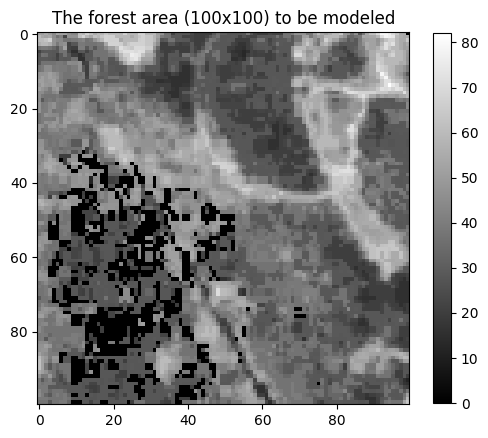

In [120]:
# Displaying the chosen area
plt.figure(figsize=(6, 6))
plt.imshow(data, cmap='gray')
plt.colorbar(shrink=0.8)
plt.title("The forest area (100x100) to be modeled")
plt.show()

In [22]:
import numpy as np

zero_count = np.sum(data == 0)
total_elements = data.size
percentage_zeros = (zero_count / total_elements) * 100

print(f"Number of zeros: {zero_count}")
print(f"Total elements: {total_elements}")
print(f"Percentage of zeros: {percentage_zeros:.2f}%")

Number of zeros: 914
Total elements: 10000
Percentage of zeros: 9.14%


# Python simpulation implementation

In [143]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

def make_animation(sim, total_frames, 
                   steps_per_frame=1, 
                   interval=100, 
                   start_y = None, start_x = None):
    """
    Generate an animated visualization of the forest fire simulation.

    Parameters:
    sim (ForestSimulator): An instance of the ForestSimulator class to animate.
    total_frames (int): The total number of frames to include in the animation.
    steps_per_frame (int): The number of simulation steps to take before updating the frame. Default is 1.
    interval (int): The time interval (in milliseconds) between frames. Default is 100.
    start_y (int, optional): The y-coordinate of the fire's starting location. Random if None.
    start_x (int, optional): The x-coordinate of the fire's starting location. Random if None.

    Returns:
    HTML: An HTML object that renders the animation in a Jupyter notebook.
    """
    def update(frame_number):
        """Updating the animation."""
        for _ in range(steps_per_frame):
            sim.update()
        sim.observe()
        progress_bar.update(1)
        return [sim.img]

    sim.initialize(start_y, start_x)
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, frames=total_frames, interval=interval
    )
    plt.close(sim.figure)
    output = HTML(animation.to_html5_video())
    return output


class ForestSimulator:
    """
    A class representing the Forest Fire Simulator, which simulates the spread of fire across a grid.
    
    Attributes:
    fire (int): Integer representing the state of a cell that is on fire.
    char (int): Integer representing the state of a cell that has been burnt.
    """
    fire, char = 2, 3 

    def __init__(self, width=100, height = 100, 
                 base_spread_rate = 1/3,
                 wind_direction = "North", 
                 wind_strength = 3, 
                 tree_density_data = data):
        """
        Initialize the forest fire simulator with specified parameters.

        Parameters:
        width (int): The width of the simulation grid.
        height (int): The height of the simulation grid.
        base_spread_rate (float): The base rate at which the fire spreads.
        wind_direction (str): The compass direction from which the wind is coming.
        wind_strength (int): The strength of the wind affecting fire spread.
        tree_density_data (np.ndarray): A 2D array representing the density of trees in each cell.
        """
        self.width = width 
        self.height = height
        self.wind_direction = wind_direction
        self.base_spread_rate = base_spread_rate
        self.wind_strength = wind_strength
        self.step_counter = 0
        # Converting the tree density into fraction
        self.tree_density = tree_density_data / 100.0

    def initialize(self, start_y = None, start_x = None):
        """
        Initialize the simulation grid and set the fire's starting location.

        Parameters:
        start_y (int, optional): The y-coordinate for the starting location of the fire.
        start_x (int, optional): The x-coordinate for the starting location of the fire.
        """
        # Initializing the grid to the tree density
        self.config = self.tree_density.copy()
        # Initializing the "next state" grid to store the next states
        self.nextconfig = np.zeros([self.height, self.width])
        self.figure, self.axes = plt.subplots()
        
        # If the fire starting coorinates are not given 
        # assigning them randomly
        if start_y is None or start_x is None:
            start_y, start_x = random.randint(0, self.height-1), random.randint(0, self.width-1)
        self.config[start_y, start_x] = self.fire
        
    def track_affected_cells(self):
        """
        Identify cells affected by the fire.

        Returns:
        set: A set of tuples indicating the coordinates of affected cells.
        """
        affected = set()
        # Going through every cell
        for y in range(self.height):
            for x in range(self.width):
                if self.config[y, x] == self.char:
                    affected.add((y, x))
                    
                    # Check all neighboring cells
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            ny, nx = (y + dy) % self.height, (x + dx) % self.width
                            affected.add((ny, nx))
        return affected

    def observe(self):
        """
        Update the visualization with the current state of the simulation grid.

        Returns:
        matplotlib.image.AxesImage: The updated image object reflecting the current simulation state.
        """
        # Creating a blank RGB image
        if not hasattr(self, 'img'):
            self.img = self.axes.imshow(np.zeros((self.height, self.width, 3)))
        
        visualization = np.zeros((self.height, self.width, 3))
        # Going through every cell
        for y in range(self.height):
            for x in range(self.width):
                cell_state = self.config[y, x]
                density = self.tree_density[y, x]
                
                # Representing no tree coverage with brown 
                if density == 0:
                    visualization[y, x] = [0.6, 0.4, 0.2]
                # Representing fire with red
                if cell_state == self.fire:
                    visualization[y, x] = [1, 0, 0]
                # Representing char with grey
                elif cell_state == self.char:
                    visualization[y, x] = [0.5, 0.5, 0.5]
                # Representing varying tree density with different shades of green
                else:
                    visualization[y, x] = [0, density, 0]

        self.img.set_data(visualization)
        self.axes.set_title(f'State at step {self.step_counter}')
        return self.img
    
    def wind_direction_to_vector(self, direction):
        """
        Convert a wind direction into a corresponding vector.

        Parameters:
        direction (str): The compass direction from which the wind is coming.

        Returns:
        np.ndarray: A unit vector representing the wind direction.
        """
        if direction == 'North':
            return np.array([0, 1])
        elif direction == 'Northeast':
            return np.array([1/np.sqrt(2), 1/np.sqrt(2)])
        elif direction == 'East':
            return np.array([1, 0])
        elif direction == 'Southeast':
            return np.array([1/np.sqrt(2), -1/np.sqrt(2)])
        elif direction == 'South':
            return np.array([0, -1])
        elif direction == 'Southwest':
            return np.array([-1/np.sqrt(2), -1/np.sqrt(2)])
        elif direction == 'West':
            return np.array([-1, 0])
        elif direction == 'Northwest':
            return np.array([-1/np.sqrt(2), 1/np.sqrt(2)])
        else:
            raise ValueError("Invalid wind direction")
        
    def calculate_wind_factor(self, wind_direction, neighbor_direction):
        """
        Calculate the wind factor based on wind direction and neighboring cell direction.

        Parameters:
        wind_direction (np.ndarray): A unit vector representing the wind direction.
        neighbor_direction (np.ndarray): A unit vector representing the direction to the neighboring cell.

        Returns:
        float: The calculated wind factor affecting fire spread probability.
        """
        # Accounting for the wind strength
        wind_vector = wind_direction * self.wind_strength
        # Normalize neighbor direction to unit vector
        # so that diagonal directions have unit length of 1 instead of sqrt(2)
        neighbor_direction = neighbor_direction / np.linalg.norm(neighbor_direction)
        # Calculating how much the wind aligns with the neighbor direction
        wind_factor = np.dot(wind_vector, neighbor_direction)
        return max(wind_factor, 0)
    
    def spread_fire(self, wind_direction, neighbor_direction, density_factor):
        """
        Determine if the fire will spread to a neighboring cell.

        Parameters:
        wind_direction (np.ndarray): A unit vector representing the wind direction.
        neighbor_direction (np.ndarray): A unit vector representing the direction to the neighboring cell.
        density_factor (float): The density of the cell being considered for fire spread.

        Returns:
        int: The state of the cell after considering fire spread.
        """
        # Calculating how much the wind is helping the fire to spread
        wind_factor = self.calculate_wind_factor(wind_direction, neighbor_direction)
        # Calculating the spread probability
        spread_probability = self.base_spread_rate * density_factor * (1 + wind_factor)
        return self.fire if np.random.rand() < spread_probability else density_factor

    def count_cells_fraction(self):
        """
        Count the fraction of burning and burnt cells.

        Returns:
        tuple: A tuple containing the fraction of cells that are burning and the fraction that are burnt.
        """
        total_cells = self.width * self.height
        burning_cells = np.sum(self.config == self.fire) / total_cells
        burnt_cells = np.sum(self.config == self.char) / total_cells
        return burning_cells, burnt_cells
    
    def count_cells(self):
        """
        Count the number of burning and burnt cells.

        Returns:
        tuple: A tuple containing the counts of cells that are burning and the counts of cells that are burnt.
        """
        total_cells = self.width * self.height
        n_burning_cells = np.sum(self.config == self.fire)
        n_burnt_cells = np.sum(self.config == self.char)
        return n_burning_cells, n_burnt_cells
    
    def update(self):
        """
        Perform a simulation step, updating the state of the grid based on the current state and fire spread rules.
        """
        self.store.append(self.config.copy())
        # Going through every cell in the forest grid
        for x in range(self.width):
            for y in range(self.height):
                cell_state = self.config[y, x]
                density_factor = self.tree_density[y, x]
                
                # Turning burning cells to char
                if cell_state == self.fire:
                    self.nextconfig[y, x] = self.char
                # Keping char as char
                elif cell_state == self.char:
                    self.nextconfig[y, x] = self.char
                # If the cell has trees
                # going through its neighbors
                else:
                    fire_nearby = False
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            # Skipping the cell itself
                            if dx == 0 and dy == 0:
                                continue
                            # Periodic boundary conditions
                            ny, nx = (y + dy) % self.height, (x + dx) % self.width
                            if self.config[ny, nx] == self.fire:
                                fire_nearby = True
                                # Negating the neighbor direction bc for the fire to spread 
                                # it should be considered from the view of the fire cell itself
                                neighbor_direction = np.array([-dy, -dx])
                                # Converting the wind direction to a vector
                                wind_vector = self.wind_direction_to_vector(self.wind_direction)
                                new_state = self.spread_fire(wind_vector, neighbor_direction, density_factor)
                                self.nextconfig[y, x] = new_state
                                break  # Breaking inner loop if fire is found
                        if fire_nearby:
                            break  # Breaking outer loop if fire is found
                    if not fire_nearby:
                        self.nextconfig[y, x] = density_factor

        self.config, self.nextconfig = self.nextconfig, self.config
        self.step_counter += 1

## Dynamic animation

In [129]:
sim = ForestSimulator()
make_animation(sim, total_frames=60, steps_per_frame=1, start_y = 50, start_x = 70) 

61it [00:02, 27.21it/s]                                                         


## Test: Wind strengths experiment

Below I am running an experiment with varying wind strength parameter values from 1 to 5. I am measuring the average fraction of burning and burnt cells.

In [133]:
import numpy as np
from scipy import stats
import scipy.stats as stats

def run_experiment(sim_class, wind_strengths, n_steps, repetitions=50):
     """
    Run a series of forest fire simulations for different wind strengths and record the results.
    
    Parameters:
    sim_class (ForestSimulator): The class of the simulator to be used for the experiment.
    wind_strengths (list): A list of wind strengths to test in the simulations.
    n_steps (int): The number of steps to run each simulation.
    repetitions (int): The number of times to repeat the simulation for each wind strength. Default is 50.

    Returns:
    list: A list of tuples, each containing:
          - wind_strength (float): The wind strength for the simulation.
          - avg_burning (float): The average fraction of cells burning at the end of the simulation.
          - avg_burnt (float): The average fraction of cells burnt at the end of the simulation.
          - burning_conf_interval (tuple): The 95% confidence interval for the fraction of burning cells.
          - burnt_conf_interval (tuple): The 95% confidence interval for the fraction of burnt cells.
    """
    results = []
    for wind_strength in wind_strengths:
        burning_data = []
        burnt_data = []
        for _ in range(repetitions):
            sim = sim_class(wind_strength=wind_strength)
            sim.initialize(start_y = 50, start_x = 70)
            for _ in range(n_steps):
                sim.update()

            burning, burnt = sim.count_cells_fraction()
            burning_data.append(burning)
            burnt_data.append(burnt)
            if sim.figure:
                plt.close(sim.figure)

        # Calculating means
        avg_burning = np.mean(burning_data)
        avg_burnt = np.mean(burnt_data)

        # Calculating 95% confidence intervals
        burning_conf_interval = stats.t.interval(0.95, len(burning_data)-1, loc=avg_burning, scale=stats.sem(burning_data))
        burnt_conf_interval = stats.t.interval(0.95, len(burnt_data)-1, loc=avg_burnt, scale=stats.sem(burnt_data))

        results.append((wind_strength, avg_burning, avg_burnt, burning_conf_interval, burnt_conf_interval))

    return results

In [134]:
wind_strengths = [1, 2, 3, 4, 5]
n_steps = 100

experiment_results = run_experiment(ForestSimulator, wind_strengths, n_steps)

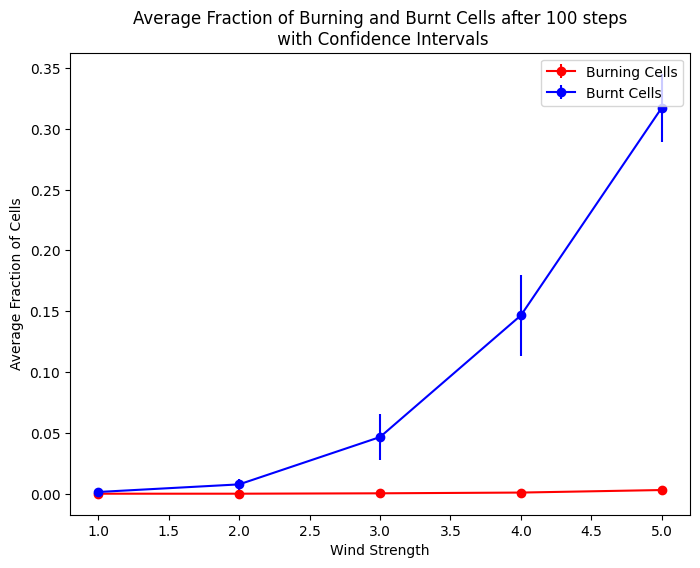

In [135]:
plt.figure(figsize=(8, 6))

# Separating the burning and burnt data for plotting
wind_strengths, avg_burnings, avg_burnts, burning_conf_intervals, burnt_conf_intervals = zip(*experiment_results)

# Converting confidence intervals into error values relative to the means
burning_errors = [[avg_burning - conf_int[0] for avg_burning, conf_int in zip(avg_burnings, burning_conf_intervals)], 
                  [conf_int[1] - avg_burning for avg_burning, conf_int in zip(avg_burnings, burning_conf_intervals)]]

burnt_errors = [[avg_burnt - conf_int[0] for avg_burnt, conf_int in zip(avg_burnts, burnt_conf_intervals)], 
                [conf_int[1] - avg_burnt for avg_burnt, conf_int in zip(avg_burnts, burnt_conf_intervals)]]


plt.errorbar(wind_strengths, avg_burnings, yerr=burning_errors, fmt='-o', color='red', label='Burning Cells')
plt.errorbar(wind_strengths, avg_burnts, yerr=burnt_errors, fmt='-o', color='blue', label='Burnt Cells')

plt.xlabel('Wind Strength')
plt.ylabel('Average Fraction of Cells')
plt.title('Average Fraction of Burning and Burnt Cells after 100 steps\n with Confidence Intervals')
plt.legend()
plt.show()

## Test: Base rate experiment

In [136]:
def run_experiment_base_rate(sim_class, base_rates, n_steps, repetitions=50):
    """
    Run a series of forest fire simulations for different base spread rates and record the results.
    
    Parameters:
    sim_class (ForestSimulator): The class of the simulator to be used for the experiment.
    base_rates (list): A list of base rates to test in the simulations.
    n_steps (int): The number of steps to run each simulation.
    repetitions (int): The number of times to repeat the simulation for each wind strength. Default is 50.

    Returns:
    list: A list of tuples, each containing:
          - wind_strength (float): The base rate for the simulation.
          - avg_burning (float): The average fraction of cells burning at the end of the simulation.
          - avg_burnt (float): The average fraction of cells burnt at the end of the simulation.
          - burning_conf_interval (tuple): The 95% confidence interval for the fraction of burning cells.
          - burnt_conf_interval (tuple): The 95% confidence interval for the fraction of burnt cells.
    """
    results = []
    for base_rate in base_rates:
        burning_data = []
        burnt_data = []
        for _ in range(repetitions):
            sim = sim_class(base_spread_rate=base_rate)
            sim.initialize(start_y = 50, start_x = 70)
            for _ in range(n_steps):
                sim.update()

            burning, burnt = sim.count_cells_fraction()
            burning_data.append(burning)
            burnt_data.append(burnt)
            if sim.figure:
                plt.close(sim.figure)

        # Calculating means
        avg_burning = np.mean(burning_data)
        avg_burnt = np.mean(burnt_data)

        # Calculating 95% confidence intervals
        burning_conf_interval = stats.t.interval(0.95, len(burning_data)-1, loc=avg_burning, scale=stats.sem(burning_data))
        burnt_conf_interval = stats.t.interval(0.95, len(burnt_data)-1, loc=avg_burnt, scale=stats.sem(burnt_data))

        results.append((base_rate, avg_burning, avg_burnt, burning_conf_interval, burnt_conf_interval))

    return results

In [137]:
base_rates = np.linspace(0.1, 1, 5)  # Example wind strengths
n_steps = 100  # Number of steps to run each simulation

experiment_results_base = run_experiment_base_rate(ForestSimulator, base_rates, n_steps)

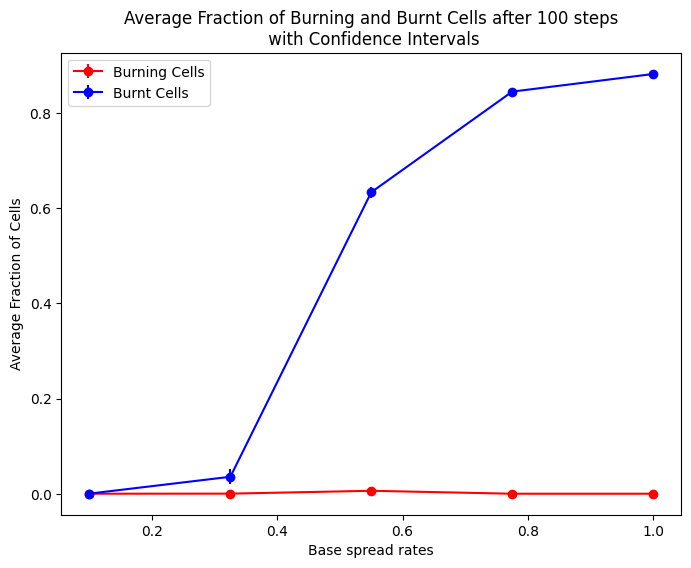

In [138]:
plt.figure(figsize=(8, 6))

# Separate the burning and burnt data for plotting
base_rates, avg_burnings, avg_burnts, burning_conf_intervals, burnt_conf_intervals = zip(*experiment_results_base)

# Convert confidence intervals into error values relative to the means
burning_errors = [[avg_burning - conf_int[0] for avg_burning, conf_int in zip(avg_burnings, burning_conf_intervals)], 
                  [conf_int[1] - avg_burning for avg_burning, conf_int in zip(avg_burnings, burning_conf_intervals)]]

burnt_errors = [[avg_burnt - conf_int[0] for avg_burnt, conf_int in zip(avg_burnts, burnt_conf_intervals)], 
                [conf_int[1] - avg_burnt for avg_burnt, conf_int in zip(avg_burnts, burnt_conf_intervals)]]

# Plot burning cells data with error bars and a line connecting the dots
plt.errorbar(base_rates, avg_burnings, yerr=burning_errors, fmt='-o', color='red', label='Burning Cells')

# Plot burnt cells data with error bars and a line connecting the dots
plt.errorbar(base_rates, avg_burnts, yerr=burnt_errors, fmt='-o', color='blue', label='Burnt Cells')

plt.xlabel('Base spread rates')
plt.ylabel('Average Fraction of Cells')
plt.title('Average Fraction of Burning and Burnt Cells after 100 steps\n with Confidence Intervals')
plt.legend()
plt.show()

# Most susceptible areas

## First three random locations: histograms

In this section, I am running the simulation with the same default parameters as above for various fire strating locations. Specifically, the three random locations are chosen using numpy and used to generate final state histograms reflecting the numbers of burnt cells. I am using the function defined below to run the simulations for various locations.

In [158]:
def fire_location_experiment(simulator_class, width, height, 
                             num_runs, num_steps,
                             start_y, start_x):
    """
    Conduct an experiment to simulate forest fires starting from a fixed location.
    
    Parameters:
    simulator_class (class): The class of the forest fire simulator to use for the experiment.
    width (int): The width of the simulation grid.
    height (int): The height of the simulation grid.
    num_runs (int): The number of times the simulation should be run.
    num_steps (int): The number of time steps to simulate for each run.
    start_y (int): The y-coordinate of the fire's starting location.
    start_x (int): The x-coordinate of the fire's starting location.

    Returns:
    list of tuples: Each tuple contains two integers representing the number of burning cells and the
                    number of burnt cells at the end of each simulation run.
    """
    results = []

    for _ in range(num_runs):     
        # Creating a new instance of the simulator
        sim = simulator_class(width, height)
        sim.initialize(start_y, start_x)
        
        # Running the simulation for the given number of steps
        for _ in range(num_steps):
            sim.update()
        
        # Recording the number of burning and burnt cells
        burning_cells, burnt_cells = sim.count_cells()
        results.append((burning_cells, burnt_cells))
        
        if sim.figure:
            plt.close(sim.figure)
    
    return results

In [157]:
# The first three random fire starting locations
height, width = 100, 100
np.random.seed(42)
y1, x1 = random.randint(0, height-1), random.randint(0, width-1)
y2, x2 = random.randint(0, height-1), random.randint(0, width-1)
y3, x3 = random.randint(0, height-1), random.randint(0, width-1)
print(f"The first random fire starting point is:{(x1, y1)}")
print(f"The second random fire starting point is:{(x2, y2)}")
print(f"The third random fire starting point is:{(x3, y3)}")

The first random fire starting point is:(34, 4)
The second random fire starting point is:(86, 8)
The third random fire starting point is:(22, 97)


In [159]:
# Running the function defined above for the given three locations
# and storing the results for visualisation
num_runs = 100
num_steps = 100

results_location1 = fire_location_experiment(ForestSimulator, 100, 100, 
                                                           num_runs, num_steps,
                                                           start_y = y1, start_x = x1)
results_location2 = fire_location_experiment(ForestSimulator, 100, 100, 
                                                           num_runs, num_steps,
                                                           start_y = y2, start_x = x2)
results_location3 = fire_location_experiment(ForestSimulator, 100, 100, 
                                                           num_runs, num_steps,
                                                           start_y = y3, start_x = x3)

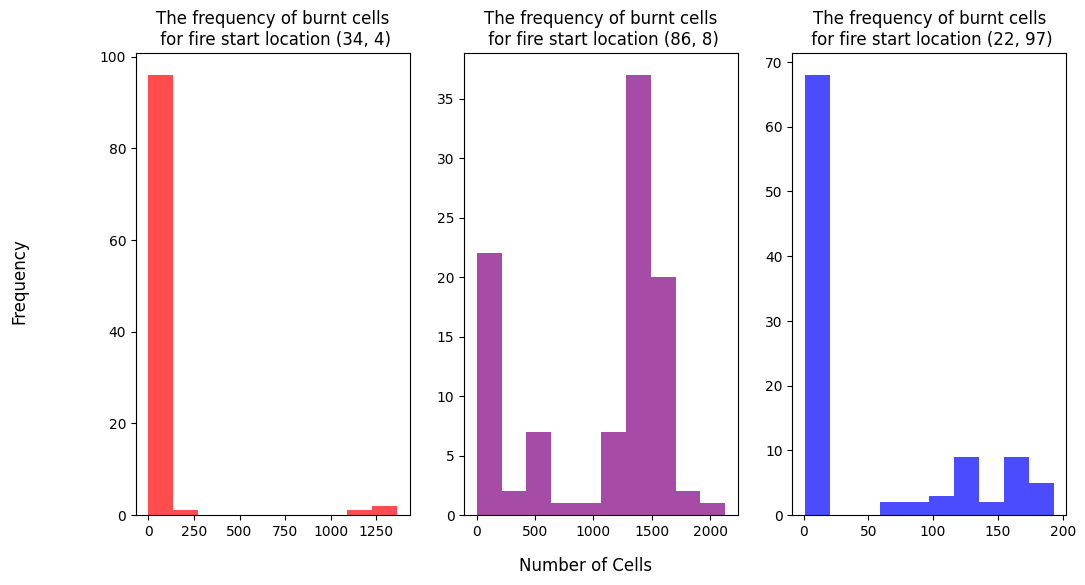

In [174]:
# Displying the frequency of observing a certain number of burnt cells given a specific
# fires tarting location
burnt_cells_location1 = [result[1] for result in results_location1]
burnt_cells_location2 = [result[1] for result in results_location2]
burnt_cells_location3 = [result[1] for result in results_location3]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
ax1.hist(burnt_cells_location1, alpha=0.7, color='red', label='Burnt Cells')
ax2.hist(burnt_cells_location2, alpha=0.7, color='purple', label='Burnt Cells')
ax3.hist(burnt_cells_location3, alpha=0.7, color='blue', label='Burnt Cells')

ax1.set_title(f"The frequency of burnt cells\n for fire start location {x1, y1}")
ax2.set_title(f"The frequency of burnt cells\n for fire start location {x2, y2}")
ax3.set_title(f"The frequency of burnt cells\n for fire start location {x3, y3}")
fig.supxlabel('Number of Cells')
fig.supylabel('Frequency')

plt.show()


## First three fire starting positions: heatmaps

In [150]:
def create_heatmap(simulator_class, width, 
                   height, num_runs, 
                   num_steps, 
                   start_y, start_x):
    """
    Runs the simulation multiple times from a fixed starting point and records the total number
    of burnt and burning cells at the end of each simulation. Also, tracks the frequency of each
    cell catching fire.
    
    Parameters:
    simulator_class (class): The class of the forest fire simulator.
    width (int): The width of the simulation grid.
    height (int): The height of the simulation grid.
    num_runs (int): The number of times the simulation should be run.
    num_steps (int): The number of time steps to simulate for each run.
    
    Returns:
    fire_frequency_map (np.array): A heatmap grid showing the frequency of cells catching fire.
    """
    # Initialize the heatmap grid to track fire frequency for each cell
    fire_frequency_map = np.zeros((height, width))

    for _ in range(num_runs):
        # Create a new instance of the simulator
        sim = simulator_class(width, height)
        sim.initialize(start_y, start_x)

        # Run the simulation for the given number of steps
        for _ in range(num_steps):
            sim.update()

        # Update the fire frequency map
        for y in range(height):
            for x in range(width):
                if sim.config[y, x] == sim.fire or sim.config[y, x] == sim.char:
                    fire_frequency_map[y, x] += 1

        # Close the figure to prevent it from displaying
        if sim.figure:
            plt.close(sim.figure)

    # Normalize the fire frequency map by the number of runs to get the probability
    fire_probability_map = fire_frequency_map / num_runs

    return fire_probability_map

In [241]:
# running the function defined above for the three locations
firemap_location1 = create_heatmap(ForestSimulator, 100, 100,
                                   num_runs, num_steps,
                                   start_y = y1, start_x = x1)
firemap_location2 = create_heatmap(ForestSimulator, 100, 100,
                                   num_runs, num_steps,
                                   start_y = y2, start_x = x2)
firemap_location3 = create_heatmap(ForestSimulator, 100, 100,
                                   num_runs, num_steps,
                                   start_y = y3, start_x = x3)

Below I am displaying the heatmaps one by one for every location.

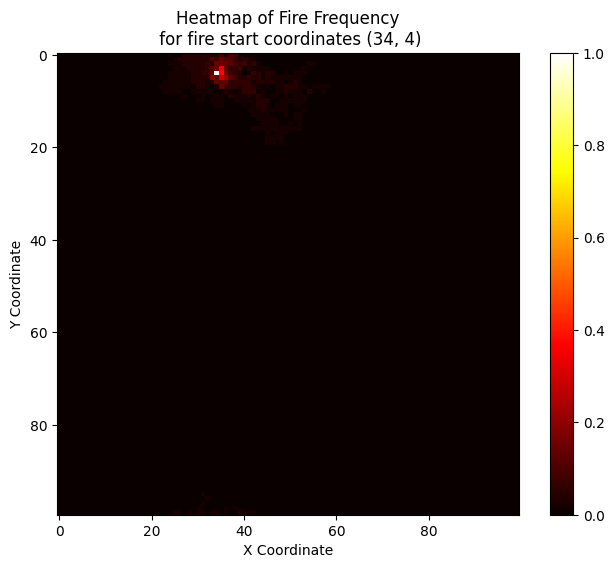

In [192]:
# Location 1 heatmap
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {x1, y1}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

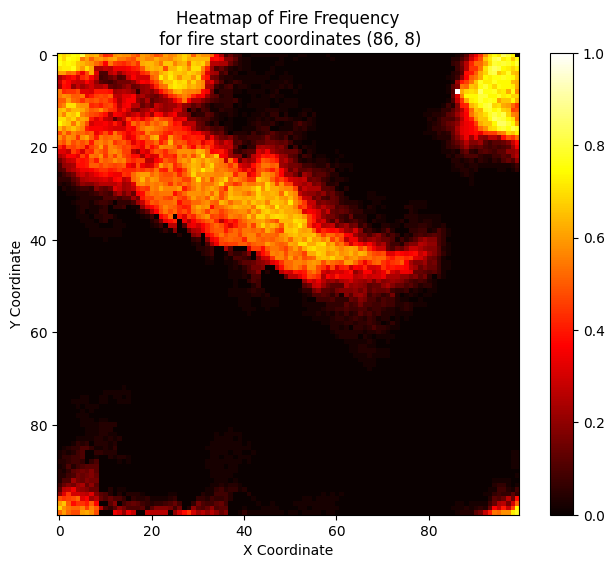

In [191]:
# Fire starting location 2 heatmap
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {x2, y2}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

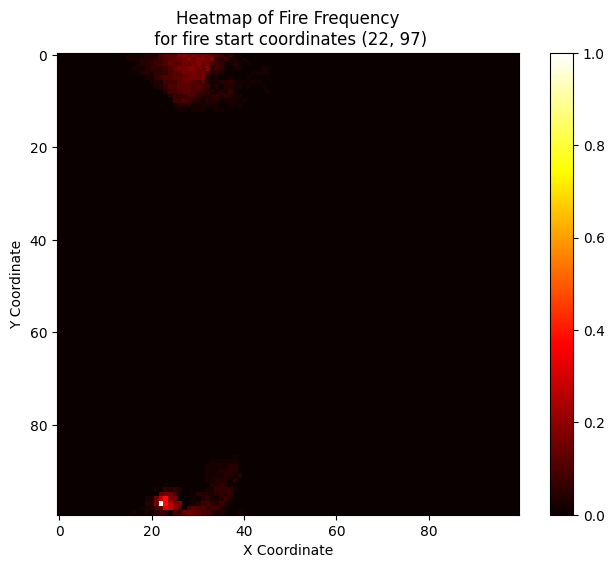

In [193]:
# fire strating location 3 heatmap
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location3, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {x3, y3}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Additional heatmaps

Below, I am running the code defined above for three more arbitrary chosen locations for a fuller analysis.

First additional location is the lower right corner.

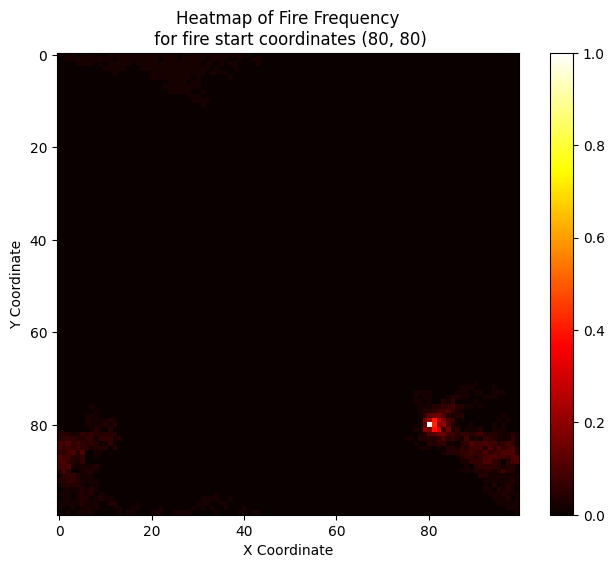

In [206]:
# Displaying first additional fire starting location heatmap
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location4, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {80, 80}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

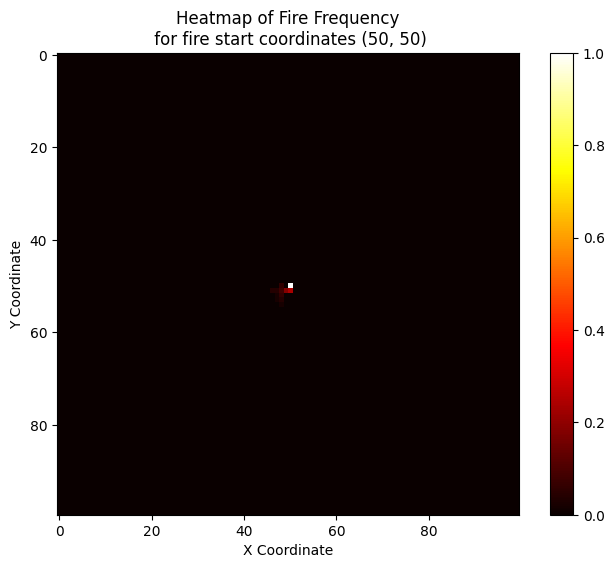

In [207]:
# Displaying second additional fire starting location heatmap
# for fire starting location (50, 50), which is the center
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location5, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {50, 50}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

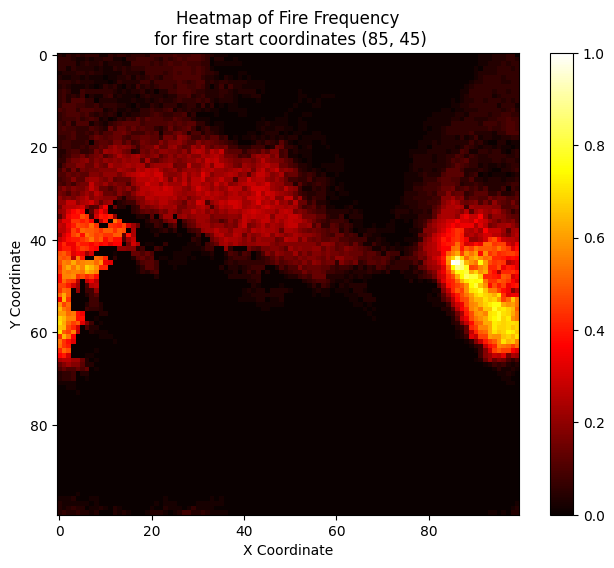

In [208]:
# Displaying third fire starting location heatmap 
# for location (85, 45)
plt.figure(figsize=(8, 6))
plt.imshow(firemap_location6, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Fire Frequency\n for fire start coordinates {85, 45}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In the code cell below, I am showing where exactly the fire is starting in each of the six scenarios above. This should aid understanding of fire behaviour in the given landscape.

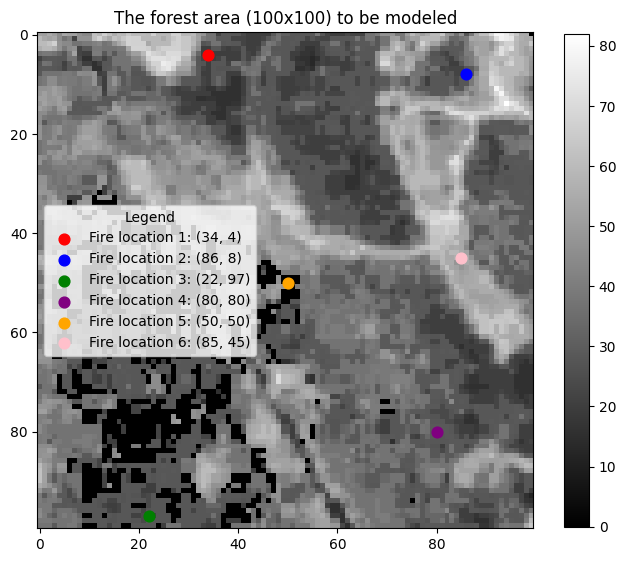

In [205]:
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='gray')
plt.colorbar(shrink=0.8)
points = {
    'Fire location 1': {'coords': (34, 4), 'color': 'red'},
    'Fire location 2': {'coords': (86, 8), 'color': 'blue'},
    'Fire location 3': {'coords': (22, 97), 'color': 'green'},
    'Fire location 4': {'coords': (80, 80), 'color': 'purple'},
    'Fire location 5': {'coords': (50, 50), 'color': 'orange'},
    'Fire location 6': {'coords': (85, 45), 'color': 'pink'}
}

for label, point_info in points.items():
    plt.scatter(*point_info['coords'], color=point_info['color'], s=60, label=f'{label}: {point_info["coords"]}')

plt.legend(loc='center left', title='Legend')

plt.title("The forest area (100x100) to be modeled")
plt.show()

# Interventions

## Wind strength intervention

In [209]:
def wind_intervention(simulator_class, width, height, 
                             num_runs, num_steps,
                             start_y, start_x,
                             wind_strength):
    """
    Run simulations to assess the impact of a specified wind strength on the spread of fire.

    Parameters:
    simulator_class (class): The class representing the forest fire simulator.
    width (int): The width of the simulation grid.
    height (int): The height of the simulation grid.
    num_runs (int): The number of simulation runs to perform.
    num_steps (int): The number of steps to execute in each simulation run.
    start_y (int): The y-coordinate for the starting location of the fire.
    start_x (int): The x-coordinate for the starting location of the fire.
    wind_strength (float): The strength of the wind to apply in the simulation.

    Returns:
    list of tuples: A list where each tuple contains the number of burning cells and the number of
                    burnt cells at the end of each simulation, allowing for analysis of the effect
                    of wind on fire spread.
    """
    results = []

    for _ in range(num_runs):     
        # A new instance of the simulator
        sim = simulator_class(width, height, wind_strength = wind_strength)
        sim.initialize(start_y, start_x)
        
        # Running the simulation for the given number of steps
        for _ in range(num_steps):
            sim.update()
        
        # Recording the number of burning and burnt cells
        burning_cells, burnt_cells = sim.count_cells()
        results.append((burning_cells, burnt_cells))
        
        if sim.figure:
            plt.close(sim.figure)
    
    return results

In [219]:
# Running the function above for the reduced wind strength scenario
wind_strength = 2
results_intervention1 = wind_intervention(ForestSimulator, 100, 100,
                                          num_runs = 200,num_steps = 100,
                                          start_y = 50, start_x = 70,
                                          wind_strength = 2)

In [220]:
# Running the function above for the default scenario for control
wind_strength = 3
results_no_intervention = wind_intervention(ForestSimulator, 100, 100,
                                          num_runs = 200, num_steps = 100,
                                          start_y = 50, start_x = 70,
                                          wind_strength = wind_strength)

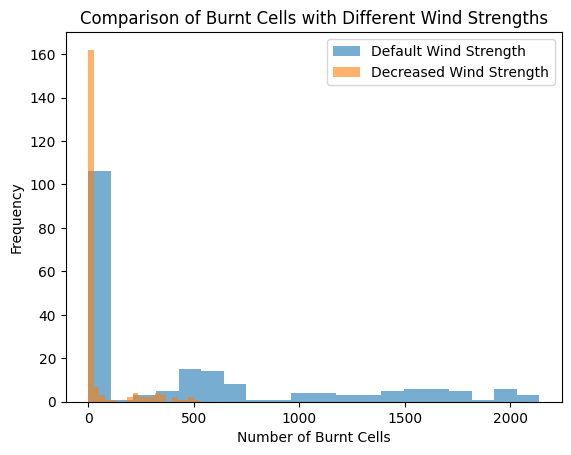

In [236]:
# Only displaying burnt cells bc the fire stops by the end of 100 steps
burnt_cells_intervention1 = [result[1] for result in results_intervention1]
burnt_cells_no_intervention = [result[1] for result in results_no_intervention]

plt.hist(burnt_cells_no_intervention, bins=20, alpha=0.6, label='Default Wind Strength')
plt.hist(burnt_cells_intervention1, bins=20, alpha=0.6, label='Decreased Wind Strength')

# Labels and title
plt.xlabel('Number of Burnt Cells')
plt.ylabel('Frequency')
plt.title('Comparison of Burnt Cells with Different Wind Strengths')
plt.legend()

plt.show()

## Wind direction intervention

In [229]:
def wind_direction_intervention(simulator_class, width, height, 
                                num_runs, num_steps,
                                start_y, start_x,
                                wind_strength, wind_direction):
    """
    Run simulations to assess the impact of a specified wind direction on the spread of fire.

    Parameters:
    simulator_class (class): The class representing the forest fire simulator.
    width (int): The width of the simulation grid.
    height (int): The height of the simulation grid.
    num_runs (int): The number of simulation runs to perform.
    num_steps (int): The number of steps to execute in each simulation run.
    start_y (int): The y-coordinate for the starting location of the fire.
    start_x (int): The x-coordinate for the starting location of the fire.
    wind_strength (float): The strength of the wind to apply in the simulation.
    wind_direction (string): The direction of the wind to apply in the simulation.

    Returns:
    list of tuples: A list where each tuple contains the number of burning cells and the number of
                    burnt cells at the end of each simulation, allowing for analysis of the effect
                    of wind direction on fire spread.
    """
    results = []

    for _ in range(num_runs):     
        sim = simulator_class(width, height, 
                              wind_strength = wind_strength, 
                              wind_direction = wind_direction)
        sim.initialize(start_y, start_x)
        
        # Running the simulation for the given number of steps
        for _ in range(num_steps):
            sim.update()
        
        # Recording the number of burning and burnt cells
        burning_cells, burnt_cells = sim.count_cells()
        results.append((burning_cells, burnt_cells))
        
        if sim.figure:
            plt.close(sim.figure)
    
    return results

In [231]:
# Running the simulation with the default wind strength but changed wind direction
wind_strength = 3
wind_direction = "Southwest"
results_dir_intervention = wind_direction_intervention(ForestSimulator, 100, 100,
                                            num_runs = 200, num_steps = 100,
                                            start_y = 50, start_x = 70,
                                            wind_strength = wind_strength, 
                                            wind_direction = wind_direction)

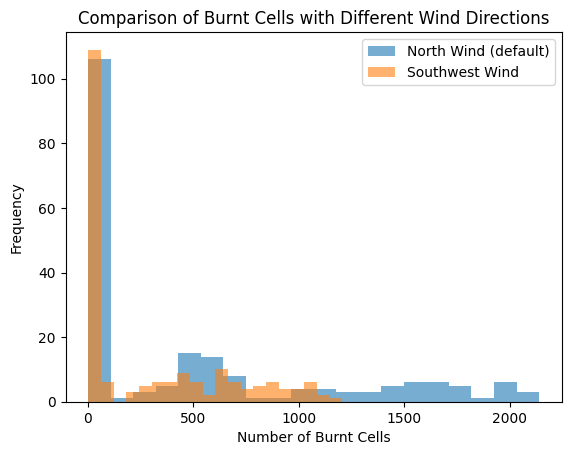

In [237]:
# Displaying the results
burnt_cells_direction = [result[1] for result in results_dir_intervention]
burnt_cells_no_intervention = [result[1] for result in results_no_intervention]

plt.hist(burnt_cells_no_intervention, bins=20, alpha=0.6, label='North Wind (default)')
plt.hist(burnt_cells_direction, bins=20, alpha=0.6, label='Southwest Wind')

plt.xlabel('Number of Burnt Cells')
plt.ylabel('Frequency')
plt.title('Comparison of Burnt Cells with Different Wind Directions')
plt.legend()

plt.show()

## Combining the wind strength and direction interventions

In [238]:
# Running the code above with both changes
wind_strength = 2
wind_direction = "Southwest"
results_intervention2 = wind_direction_intervention(ForestSimulator, 100, 100,
                                            num_runs = 200, num_steps = 100,
                                            start_y = 50, start_x = 70,
                                            wind_strength = wind_strength, 
                                            wind_direction = wind_direction)

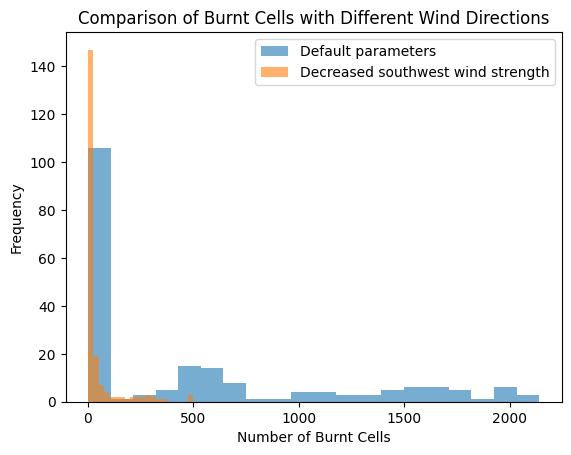

In [239]:
# Displaying the default simulation results and the simulation 
# results with decreased wind strength and diferent direction
burnt_cells_intervention2 = [result[1] for result in results_intervention2]
burnt_cells_no_intervention = [result[1] for result in results_no_intervention]

plt.hist(burnt_cells_no_intervention, bins=20, alpha=0.6, label='Default parameters')
plt.hist(burnt_cells_intervention2, bins=20, alpha=0.6, label='Decreased southwest wind strength')

plt.xlabel('Number of Burnt Cells')
plt.ylabel('Frequency')
plt.title('Comparison of Burnt Cells with Different Wind Directions')
plt.legend()

plt.show()